## CST 383: Intro to Data Science
# Project 2 

# Predicting Kickstarter Campaign Success
## Authors: Brianna Magallon, Tyler Pruitt, Rafael Reis

# Introduction: 
### In this project, we use the Kickstarter Projects dataset to predict whether a campaign will be successful or not based on features such as ...
### Dataset URL: https://www.kaggle.com/datasets/kemical/kickstarter-projects

In [4]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# plotting
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

## Read the data

In [8]:
# df = pd.read_csv("ks-projects-201612.csv", low_memory = False)
df = pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False) # to make encoding work, at elast on macOS

In [12]:
df.columns = df.columns.str.strip()
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
177780,2058799484,Compassionate Eating Ventura - Organic Farm Bo...,Food,Food,USD,2012-10-26 18:05:54,5000,2012-09-26 18:05:54,2597,failed,21,US,2597,NaN,NaN,NaN,NaN
180498,2074883702,The LuLu Sessions - feature documentary film,Documentary,Film & Video,USD,2011-05-07 01:48:57,12000,2011-04-05 01:48:57,12050,successful,45,US,12050,NaN,NaN,NaN,NaN
165934,1986975542,From Trail to Summit: A Colorado Climbing Docu...,Documentary,Film & Video,USD,2015-05-01 04:00:00,60000,2015-03-31 20:28:38,1505,failed,10,US,1505,NaN,NaN,NaN,NaN
262968,635270331,Metaly - Metal of Italy,Technology,Technology,EUR,2016-05-29 10:27:47,25000,2016-04-29 10:27:47,34,failed,1,IT,38.53245738,NaN,NaN,NaN,NaN
97627,1579865589,We Like Laughter,Film & Video,Film & Video,GBP,2013-12-14 10:19:03,5500,2013-11-14 10:19:03,7040.3,successful,143,GB,11187.332181391,NaN,NaN,NaN,NaN


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323751 entries, 0 to 323750
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323751 non-null  object 
 1   name           323747 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   deadline       323750 non-null  object 
 6   goal           323750 non-null  object 
 7   launched       323750 non-null  object 
 8   pledged        323750 non-null  object 
 9   state          323750 non-null  object 
 10  backers        323750 non-null  object 
 11  country        323750 non-null  object 
 12  usd pledged    319959 non-null  object 
 13  Unnamed: 13    625 non-null     object 
 14  Unnamed: 14    12 non-null      object 
 15  Unnamed: 15    4 non-null       object 
 16  Unnamed: 16    1 non-null       float64
dtypes: float64(1), object(16)
mem

## Data Exploration

In [19]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [23]:
df['state'].value_counts()

state
failed        168220
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
2312               1
320                1
477                1
1404               1
2634               1
Name: count, Length: 410, dtype: int64

In [25]:
df[df['state'] == "canceled"].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN
59,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000,2015-07-08 21:46:53,700,canceled,6,CA,553.324254,NaN,NaN,NaN,NaN
61,1000260691,Gizbee Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000,2016-02-29 20:30:27,2030,canceled,15,US,2030,NaN,NaN,NaN,NaN


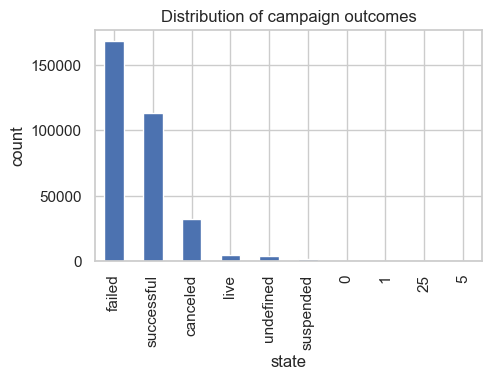

In [27]:
state_counts = df['state'].value_counts().head(10)
state_counts.plot.bar()
plt.title('Distribution of campaign outcomes')
plt.xlabel('state')
plt.ylabel('count')
plt.show()

In [29]:
df.sample(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
105256,1625142392,Uncle Giff's Christmas Special,Musical,Theater,USD,2014-09-28 05:59:00,2500,2014-09-02 21:49:26,2591,successful,47,US,2591,NaN,NaN,NaN,NaN
37996,1225444603,Combat Paper Program,Art,Art,USD,2012-03-21 03:28:03,15000,2012-02-20 04:28:03,19000,successful,321,US,19000,NaN,NaN,NaN,NaN
163171,1970392912,The Crystal Crypt: Based on a short story by P...,Shorts,Film & Video,USD,2013-03-18 07:59:00,25000,2013-01-28 18:46:47,15463,failed,152,US,15463,NaN,NaN,NaN,NaN
119994,1712250398,What is Janet Lynn?,Shorts,Film & Video,USD,2012-04-01 22:27:08,6000,2012-03-02 22:27:08,6050,successful,57,US,6050,NaN,NaN,NaN,NaN
181822,2082919392,MyTown's Kitchen Project,Food,Food,USD,2012-06-01 05:38:24,7000,2012-05-02 05:38:24,245,failed,4,US,245,NaN,NaN,NaN,NaN
48871,129044575,A Magazine for the Future,Print,Journalism,USD,2015-06-01 20:04:09,10000,2015-04-17 20:04:09,75,failed,2,US,75,NaN,NaN,NaN,NaN
268111,665723203,Celebrating the enduring gesture,Technology,Technology,AUD,2016-06-21 05:13:57,13500,2016-05-06 05:13:57,131,failed,5,AU,98.00034413,NaN,NaN,NaN,NaN
75410,1448256549,MeterMagic,Apps,Technology,USD,2016-04-15 15:52:39,80000,2016-03-01 15:52:39,72,failed,5,US,72,NaN,NaN,NaN,NaN
275082,707402296,Dream Killa (Music Video),Film & Video,Film & Video,USD,2013-06-06 23:31:09,8000,2013-04-07 23:31:09,499,failed,1,US,499,NaN,NaN,NaN,NaN
130724,1776035212,Wind Playground,Sculpture,Art,USD,2012-04-22 01:44:02,25000,2012-02-22 01:44:02,25253,successful,118,US,25253,NaN,NaN,NaN,NaN


## Preprocessing /Data Cleaning

In [31]:
df = df.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [33]:
df.sample(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
35801,1212826883,Standing Out In The Crowd,Documentary,Film & Video,USD,2015-04-29 21:42:11,24000,2015-03-30 21:42:11,2794,failed,40,US,2794
310207,918768928,Psycho University (Canceled),Thrillers,Film & Video,USD,2016-05-24 02:00:25,8769,2016-03-25 01:00:25,0,canceled,0,US,0
6873,1040396379,Kitchen Shop*Eat*Learn,Food,Food,USD,2013-12-23 13:05:02,56000,2013-11-23 13:05:02,4061,failed,19,US,4061
241656,50677284,Hope Is Growing t-shirts promote early detection,Apparel,Fashion,USD,2014-12-03 23:11:49,2489,2014-11-03 23:11:49,0,failed,0,US,0
152833,190828137,Apex Racewear : Affordable racewear for everyone,Apparel,Fashion,GBP,2015-02-26 14:24:00,3500,2015-01-27 14:24:00,1,failed,1,GB,1.49968207
200807,262857898,No Way Out,Documentary,Film & Video,USD,2014-05-28 09:56:17,100000,2014-03-29 08:56:17,2562,failed,31,US,2562
228373,42775922,15x15 Clam Shell Digital Sublimation Heat pres...,Crafts,Crafts,USD,2015-04-29 17:03:46,400,2015-03-30 17:03:46,1,failed,1,US,1
166302,1989487106,TruStump Deer and Wildlife Feeder,Product Design,Design,USD,2015-12-02 18:50:58,47500,2015-11-02 18:50:58,6650,failed,16,US,6650
95794,1569029107,Kikeriki! - the cool band for cool kids - Debu...,Pop,Music,AUD,2013-12-20 10:47:19,52000,2013-11-20 10:47:19,7592,failed,37,AU,7114.93640936
157584,1937497350,Fujian Trader: A board game adventure in Chine...,Tabletop Games,Games,USD,2015-03-19 22:30:00,39500,2015-02-11 16:08:53,40032.5,successful,464,US,40032.5


In [35]:
df[df.isnull().any(axis=1)].sample(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
186792,2111834002,Kev Bev Collins and the Woodland Creatures Alb...,Music,Music,USD,2015-07-07 00:24:42,6000,2015-06-07 22:14:34,7732,undefined,0,"N,""0",NaN
100064,1594456646,585 Live,Music,Music,USD,2015-06-20 05:42:09,2500,2015-06-05 05:42:09,0,undefined,0,"N,""0",NaN
114985,1682155571,GetYourMusicNoticed Launch Event Ft. Grey Season!,Music,Music,USD,2014-10-31 17:00:00,3500,2014-10-05 20:30:37,3500,undefined,0,"N,""0",NaN
306142,894151830,Earth Mama Soul Tells It Like It Is,Publishing,Publishing,USD,2015-04-19 20:57:35,3000,2015-03-20 19:57:35,575,undefined,0,"N,""0",NaN
57229,1339974512,Rugged Grace Album,Music,Music,USD,2015-03-11 16:44:36,1500,2015-02-09 17:44:36,1830,undefined,0,"N,""0",NaN
40756,1242474294,"Chena Kovax EP ""OBSESSION""",Music,Music,USD,2015-05-12 16:40:32,3000,2015-03-13 15:40:32,96,undefined,0,"N,""0",NaN
67989,1404454953,Adam Alb Originals,Music,Music,USD,2015-07-31 03:58:03,3000,2015-07-01 03:58:03,20,undefined,0,"N,""0",NaN
173466,2032497194,The Spokes - HellaCappella 2015 - A Cappella S...,Music,Music,USD,2015-03-26 19:30:51,2000,2015-03-06 20:30:51,2120,undefined,0,"N,""0",NaN
302214,870322805,"""Color"" Music Video",Music,Music,USD,2015-09-16 00:03:02,1100,2015-09-02 00:03:02,1100,undefined,0,"N,""0",NaN
48896,129057375,BRUNSDON FILMS,Film & Video,Film & Video,GBP,2016-01-19 19:57:51,5000,2015-11-20 19:57:51,7,undefined,0,"N,""0",NaN


In [37]:
df = df.rename(columns={"state ": "state"}) # There's a trailing space in the column name that is annoying
df = df[df['state'].isin(["successful", "failed	", "canceled"])]

In [39]:
print("Rows still with null values: ", len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)].sample(5)

Rows still with null values:  127


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
271407,685752214,"Tizmoret's 20th Year Album : ""Score""",Music,Music,USD,2016-05-31 06:00:00,5000,2016-05-02 04:07:09,5427,successful,0,"N,""0",NaN
99800,1593022694,Wondermare's First Album,Music,Music,GBP,2016-05-04 21:10:48,800,2016-04-04 21:10:48,905,successful,0,"N,""0",NaN
134125,1797015410,"3 years in the making, 18 Epic songs, one Woman.",Music,Music,USD,2016-04-28 05:14:00,5000,2016-03-15 17:55:00,5075,successful,0,"N,""0",NaN
258831,610154753,'MIA 2 LAX' The Track Burnaz Debut EP,Music,Music,USD,2016-05-08 10:07:43,2000,2016-04-08 10:07:43,2452,successful,0,"N,""0",NaN
144056,185596978,Jenni Noyes Debut Album - In Darkness & Light,Music,Music,GBP,2016-05-12 10:15:00,3200,2016-04-12 10:15:00,3468,successful,0,"N,""0",NaN


It seems the vast majority of Kickstarter campaigns with null values fall under the Music and Film categories, often with zero backers. The campaign states vary, which likely reflects that creating music or films isn’t strongly tied to financial backing (there’s probably a joke in there somewhere).

Since these projects lack key information like backer count or country and only account for 127 rows, we’ll remove them from the dataset.

In [41]:
df = df.dropna()
len(df[df.isnull().any(axis=1)]) # checking
df.info() # Current state

<class 'pandas.core.frame.DataFrame'>
Index: 145308 entries, 3 to 323746
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             145308 non-null  object
 1   name           145308 non-null  object
 2   category       145308 non-null  object
 3   main_category  145308 non-null  object
 4   currency       145308 non-null  object
 5   deadline       145308 non-null  object
 6   goal           145308 non-null  object
 7   launched       145308 non-null  object
 8   pledged        145308 non-null  object
 9   state          145308 non-null  object
 10  backers        145308 non-null  object
 11  country        145308 non-null  object
 12  usd pledged    145308 non-null  object
dtypes: object(13)
memory usage: 15.5+ MB


In [45]:
df['backers'].info()

<class 'pandas.core.series.Series'>
Index: 145308 entries, 3 to 323746
Series name: backers
Non-Null Count   Dtype 
--------------   ----- 
145308 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [63]:
df['goal'] = pd.to_numeric(df['goal'], errors='coerce').astype(int)
# df.dropna(subset=['goal'], inplace=True)
print(df['goal'])

0          19500
1          50000
2           1000
3         125000
4          65000
           ...  
145303       500
145304      5000
145305     20000
145306      5500
145307     50000
Name: goal, Length: 145308, dtype: int32
